In [ ]:
#### Examples from Mathematical Programming for Power Systems Operation: From Theory to Applications in Python

In [3]:
import numpy as np  
import networkx as nx 

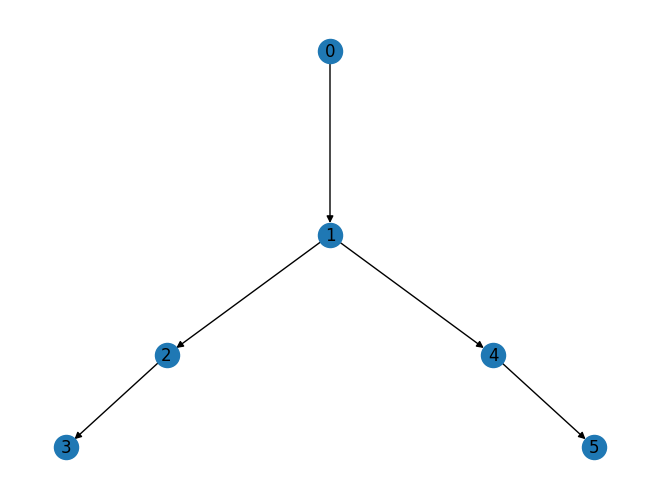

In [ ]:
# creating a graph based on node-descriptions. Y is the admitance of each edge. Nodes has an Smax for production or a d for load definition
G = nx.DiGraph() 
G.add_node(0,name='slack',smax=10,d=0) 
G.add_node(1,name='step',smax=0,d=0) 
G.add_node(2,name='house',smax=0,d=1.2+0.3j) 
G.add_node(3,name='solar',smax=1,d=0) 
G.add_node(4,name='building',smax=0,d=2.5+0.9j) 
G.add_node(5,name='wind',smax=1.5,d=0) 
G.add_edge(0,1,y=1/(0.0075+0.010j),thlim=2) 
G.add_edge(1,2,y=1/(0.0080+0.011j),thlim=2)
G.add_edge(2,3,y=1/(0.0090+0.018j),thlim=2) 
G.add_edge(1,4,y=1/(0.0040+0.004j),thlim=2) 
G.add_edge(4,5,y=1/(0.0050+0.006j),thlim=2) 
nx.draw(G,with_labels=True,pos=nx.spectral_layout(G))

In [ ]:
A = nx.incidence_matrix(G,oriented=True) # creating an incidence matrix to describe how the edges and nodes are connected (with direction 1 for positive and -1 for negative)
print(f'Incidence matrix A: \n{A}')
Yp = np.diag([G.edges[k]['y'] for k in G.edges]) # create a admittance matrix by adding the admittance values for each branch to the matrix
print(f'Diagonal admittance matrix Yp: \n{Yp}')
Ybus = A@Yp@A.T
print(f'Y bus matrix \n{Ybus}')  
print(f'Eigenvalues: \n {np.linalg.eigvals(Ybus.real)}')

Incidence matrix A: 
<Compressed Sparse Column sparse array of dtype 'float64'
	with 10 stored elements and shape (6, 5)>
  Coords	Values
  (0, 0)	-1.0
  (1, 0)	1.0
  (1, 1)	-1.0
  (2, 1)	1.0
  (1, 2)	-1.0
  (4, 2)	1.0
  (2, 3)	-1.0
  (3, 3)	1.0
  (4, 4)	-1.0
  (5, 4)	1.0
Diagonal admittance matrix Yp: 
[[ 48.         -64.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j          43.24324324 -59.45945946j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
  125.        -125.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j          22.22222222 -44.44444444j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
   81.96721311 -98.36065574j]]
Y bus matrix 
[[  48.         -64.j          -48

In [17]:
n = G.number_of_nodes() 
YN0 = Ybus[1:n,0] 
Y0N = Ybus[0,1:n] 
YNN = Ybus[1:n,1:n] 
ZNN = np.linalg.inv(YNN) 
d = np.array([G.nodes[k]['d'] for k in G.nodes]) 
print(f'YN0:\n{YN0}') 
print(f'Y0N:\n{Y0N}') 
print(f'YNN:\n{YNN}') 

YN0:
[-48.+64.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j]
Y0N:
[-48.+64.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j]
YNN:
[[ 216.24324324-248.45945946j  -43.24324324 +59.45945946j
     0.          +0.j         -125.        +125.j
     0.          +0.j        ]
 [ -43.24324324 +59.45945946j   65.46546547-103.9039039j
   -22.22222222 +44.44444444j    0.          +0.j
     0.          +0.j        ]
 [   0.          +0.j          -22.22222222 +44.44444444j
    22.22222222 -44.44444444j    0.          +0.j
     0.          +0.j        ]
 [-125.        +125.j            0.          +0.j
     0.          +0.j          206.96721311-223.36065574j
   -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j          -81.96721311 +98.36065574j
    81.96721311 -98.36065574j]]


In [18]:
def LoadFlow(sN,dN): 
    v0 = 1+0j 
    vN = np.ones(n-1)*v0 
    for t in range(10):  
        vN = ZNN@(np.conj((sN-dN)/vN)-v0*YN0) 
        vT = np.hstack([v0,vN]); sT = vT*np.conj(Ybus@vT) 
        err = np.linalg.norm(sT[1:n]-(sN-dN)) 
        print('Load Flow, after 10 iterations the error is',err)  
        return vT

In [19]:
VT = LoadFlow(np.zeros(n-1),d[1:n]) 
ST = VT*np.conj(Ybus@VT) 
pL = sum(ST) 
print('Loss',pL) 
for (k,m) in G.edges: 
    Sf = Ybus[k,m]*(VT[k]-VT[m]) 
    print('flow',(k,m),np.abs(Sf))

Load Flow, after 10 iterations the error is 0.18706514927959333
Loss (0.1539549999999772+0.19637000000002514j)
flow (0, 1) 3.8897300677553015
flow (1, 2) 1.2369316876852838
flow (1, 4) 2.657066051117307
flow (2, 3) 3.447964101732324e-16
flow (4, 5) 0.0
